In [29]:
import _nb_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from config import *
from data import *
from utils import *
from color_map import apply_colormap, COLOR_MAP_VOID_DICT
from model import *

from functools import partial
from collections import OrderedDict
from torch import nn
from torchvision.transforms.functional import to_pil_image
from torchvision.models import segmentation as segmodels
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights
from torchvision.models.mobilenetv3 import mobilenet_v3_large, MobileNet_V3_Large_Weights, MobileNetV3
from torchvision.transforms._presets import SemanticSegmentation
from torchvision.utils import draw_segmentation_masks
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import MulticlassAccuracy

In [31]:
IMAGE_SIZE = 520

In [32]:
train_ds = SegDataset(image_train_UIDs, IMAGE_SIZE, CLASS_MAP_VOID)
val_ds = SegDataset(image_val_UIDs, IMAGE_SIZE, CLASS_MAP_VOID)
len(train_ds), len(val_ds)

(1464, 1449)

In [33]:
model = segmodels.lraspp_mobilenet_v3_large(
    weights=None, # initialised decoder
    # weights=segmodels.LRASPP_MobileNet_V3_Large_Weights.DEFAULT, # pre-trained decoder
    weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V2 # pre-trained backbone
)
model.to(CONFIG["device"])
model.eval()

preprocess = partial(SemanticSegmentation, resize_size=IMAGE_SIZE)() # same as default transforms, but resize to 224 (instead of 520), as original backbone is trained on 224x224 ImageNet pictures.

In [34]:
model.backbone.requires_grad_(False)
model.classifier.requires_grad_(True);

In [35]:
collate_fn = partial(extract_augment_preprocess_batch, augment_fn=None, preprocess_fn=preprocess)

In [36]:
lr = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=21)

In [37]:
B = 16
T = 100 # num. epochs

In [38]:
train_dl = DataLoader(
    train_ds,
    batch_size=B,
    shuffle=True,
    generator=torch_gen,
    collate_fn=collate_fn,
)
val_dl = DataLoader(
    train_ds,
    batch_size=B,
    generator=torch_gen,
    collate_fn=collate_fn,
)

In [39]:
metrics_dict = {
    "acc": MulticlassAccuracy(NUM_CLASSES_VOID, 1, "micro", "global", ignore_index=21).to(CONFIG["device"]),
    "mIoU": MeanIoU(NUM_CLASSES, include_background=True, per_class=False, input_format="index").to(CONFIG["device"])
}

In [44]:
class_pixel_counts, class_pixel_distribution_percentage = class_pixel_distribution(train_dl, NUM_CLASSES_VOID)

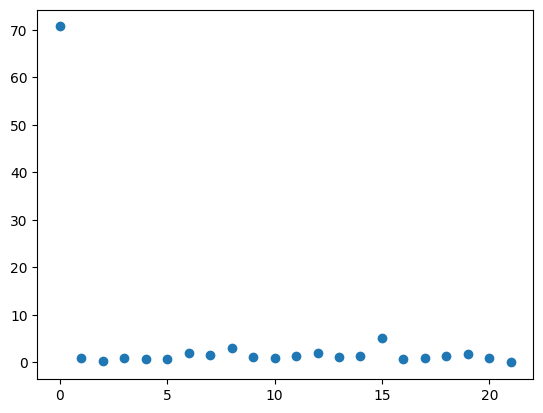

In [50]:
import matplotlib.pyplot as plt
plt.scatter(range(0, 22), class_pixel_distribution_percentage.cpu())

In [12]:
# TODO assert complete data reproducility
# TODO speed up things
# TODO refactor everything
# TODO implement TensorBoard
# TODO check if the pre-processing can in be coded better.
# TODO try SegmentationModels library

if get_compute_capability() >= 7.0:
    model = torch.compile(model)

print(f"- Train. data-loader of {len(train_dl)} mini-batches of size {B}")
print(f"- Val. data-loader of {len(val_dl)} mini-batches of size {B}")
display(Markdown("---"))

train_metrics = tm.MetricCollection(metrics_dict)

for epoch in range(T):

    train_metrics.reset()

    running_loss = None
    progress_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{T}")

    for step, (scs, gts) in enumerate(progress_bar):

        model.train()

        scs = scs.to(CONFIG["device"])
        gts = gts.to(CONFIG["device"])

        optimizer.zero_grad()

        logits: Tensor = model(scs)
        logits = logits["out"] if isinstance(logits, OrderedDict) else logits

        batch_loss = criterion(logits, gts)
        batch_loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0) # clip gradients
        optimizer.step()

        postfixes = {}
        postfixes["batch_loss"] = f"{batch_loss:.4f}"
        postfixes = postfixes | pretty_metrics(train_metrics(logits.argmax(dim=1), gts))
        postfixes["lr"] = f"{lr:.2e}"
        postfixes["grad_norm"] = f"{grad_norm:.2f}"

        progress_bar.set_postfix(postfixes)

        torch.cuda.synchronize() if CONFIG["device"] == "cuda" else None

    loss, val_metrics_score = evaluate(model, val_dl, criterion, metrics_dict)
    print({"loss": f"{loss:.4f}"} | pretty_metrics(val_metrics_score))

display(Markdown("---"))

- Train. data-loader of 92 mini-batches of size 16
- Val. data-loader of 92 mini-batches of size 16


---

Evaluation: 100%|██████████| 92/92 [01:34<00:00,  1.03s/it]


{'loss': '3.2281', 'acc': '0.2658', 'mIoU': '0.0187'}


Evaluation: 100%|██████████| 92/92 [01:46<00:00,  1.16s/it]


{'loss': '2.5260', 'acc': '0.3979', 'mIoU': '0.0281'}


Evaluation: 100%|██████████| 92/92 [01:39<00:00,  1.08s/it]


{'loss': '1.9705', 'acc': '0.5224', 'mIoU': '0.0368'}


Evaluation: 100%|██████████| 92/92 [01:23<00:00,  1.11it/s]


{'loss': '1.5904', 'acc': '0.6137', 'mIoU': '0.0430'}


Evaluation: 100%|██████████| 92/92 [01:42<00:00,  1.12s/it]


{'loss': '1.3213', 'acc': '0.6786', 'mIoU': '0.0472'}


Evaluation: 100%|██████████| 92/92 [01:46<00:00,  1.16s/it]


{'loss': '1.1507', 'acc': '0.7176', 'mIoU': '0.0504'}


Evaluation: 100%|██████████| 92/92 [01:21<00:00,  1.12it/s]


{'loss': '1.0332', 'acc': '0.7424', 'mIoU': '0.0539'}


Evaluation: 100%|██████████| 92/92 [01:35<00:00,  1.04s/it]


{'loss': '0.9510', 'acc': '0.7577', 'mIoU': '0.0581'}


Evaluation: 100%|██████████| 92/92 [01:47<00:00,  1.16s/it]


{'loss': '0.8938', 'acc': '0.7677', 'mIoU': '0.0622'}


Evaluation: 100%|██████████| 92/92 [01:30<00:00,  1.01it/s]


{'loss': '0.8441', 'acc': '0.7768', 'mIoU': '0.0674'}


Evaluation: 100%|██████████| 92/92 [01:29<00:00,  1.03it/s]


{'loss': '0.8075', 'acc': '0.7831', 'mIoU': '0.0719'}


Evaluation: 100%|██████████| 92/92 [01:45<00:00,  1.15s/it]


{'loss': '0.7745', 'acc': '0.7890', 'mIoU': '0.0765'}


Evaluation: 100%|██████████| 92/92 [01:34<00:00,  1.03s/it]


{'loss': '0.7477', 'acc': '0.7942', 'mIoU': '0.0816'}


Evaluation: 100%|██████████| 92/92 [01:21<00:00,  1.13it/s]


{'loss': '0.7231', 'acc': '0.7979', 'mIoU': '0.0875'}


Evaluation: 100%|██████████| 92/92 [01:46<00:00,  1.16s/it]


{'loss': '0.7023', 'acc': '0.8027', 'mIoU': '0.0919'}


Evaluation: 100%|██████████| 92/92 [01:27<00:00,  1.05it/s]


{'loss': '0.6807', 'acc': '0.8059', 'mIoU': '0.1014'}


Evaluation: 100%|██████████| 92/92 [01:31<00:00,  1.00it/s]


{'loss': '0.6651', 'acc': '0.8094', 'mIoU': '0.1046'}


Evaluation: 100%|██████████| 92/92 [01:46<00:00,  1.15s/it]


{'loss': '0.6506', 'acc': '0.8124', 'mIoU': '0.1077'}


Evaluation: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s]


{'loss': '0.6346', 'acc': '0.8158', 'mIoU': '0.1143'}


Evaluation: 100%|██████████| 92/92 [01:43<00:00,  1.12s/it]


{'loss': '0.6195', 'acc': '0.8188', 'mIoU': '0.1242'}


Evaluation: 100%|██████████| 92/92 [01:38<00:00,  1.07s/it]


{'loss': '0.6065', 'acc': '0.8215', 'mIoU': '0.1286'}


Evaluation: 100%|██████████| 92/92 [01:31<00:00,  1.01it/s]


{'loss': '0.5971', 'acc': '0.8233', 'mIoU': '0.1325'}


Evaluation: 100%|██████████| 92/92 [01:43<00:00,  1.13s/it]


{'loss': '0.5858', 'acc': '0.8263', 'mIoU': '0.1354'}


Evaluation: 100%|██████████| 92/92 [01:37<00:00,  1.06s/it]


{'loss': '0.5726', 'acc': '0.8294', 'mIoU': '0.1457'}


Evaluation: 100%|██████████| 92/92 [01:35<00:00,  1.03s/it]


{'loss': '0.5635', 'acc': '0.8311', 'mIoU': '0.1517'}


Evaluation: 100%|██████████| 92/92 [01:42<00:00,  1.12s/it]


{'loss': '0.5541', 'acc': '0.8340', 'mIoU': '0.1513'}


Evaluation: 100%|██████████| 92/92 [01:38<00:00,  1.07s/it]


{'loss': '0.5445', 'acc': '0.8357', 'mIoU': '0.1635'}


Evaluation: 100%|██████████| 92/92 [01:16<00:00,  1.19it/s]


{'loss': '0.5337', 'acc': '0.8384', 'mIoU': '0.1663'}


Evaluation: 100%|██████████| 92/92 [01:43<00:00,  1.12s/it]


{'loss': '0.5257', 'acc': '0.8404', 'mIoU': '0.1717'}


Evaluation: 100%|██████████| 92/92 [01:34<00:00,  1.02s/it]


{'loss': '0.5187', 'acc': '0.8424', 'mIoU': '0.1729'}


Evaluation: 100%|██████████| 92/92 [01:12<00:00,  1.28it/s]


{'loss': '0.5112', 'acc': '0.8433', 'mIoU': '0.1859'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.74it/s]


{'loss': '0.5019', 'acc': '0.8455', 'mIoU': '0.1933'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.76it/s]


{'loss': '0.4952', 'acc': '0.8470', 'mIoU': '0.1985'}


Evaluation: 100%|██████████| 92/92 [00:51<00:00,  1.77it/s]


{'loss': '0.4875', 'acc': '0.8494', 'mIoU': '0.2006'}


Evaluation: 100%|██████████| 92/92 [00:51<00:00,  1.79it/s]


{'loss': '0.4811', 'acc': '0.8505', 'mIoU': '0.2111'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


{'loss': '0.4739', 'acc': '0.8523', 'mIoU': '0.2141'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


{'loss': '0.4692', 'acc': '0.8540', 'mIoU': '0.2176'}


Evaluation: 100%|██████████| 92/92 [00:51<00:00,  1.78it/s]


{'loss': '0.4615', 'acc': '0.8555', 'mIoU': '0.2263'}


Evaluation: 100%|██████████| 92/92 [00:51<00:00,  1.78it/s]


{'loss': '0.4560', 'acc': '0.8570', 'mIoU': '0.2293'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


{'loss': '0.4490', 'acc': '0.8589', 'mIoU': '0.2371'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.76it/s]


{'loss': '0.4444', 'acc': '0.8598', 'mIoU': '0.2449'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.77it/s]


{'loss': '0.4387', 'acc': '0.8617', 'mIoU': '0.2446'}


Evaluation: 100%|██████████| 92/92 [00:51<00:00,  1.79it/s]


{'loss': '0.4329', 'acc': '0.8630', 'mIoU': '0.2496'}


Evaluation: 100%|██████████| 92/92 [00:52<00:00,  1.75it/s]


{'loss': '0.4297', 'acc': '0.8645', 'mIoU': '0.2539'}


Evaluation: 100%|██████████| 92/92 [00:53<00:00,  1.72it/s]


{'loss': '0.4236', 'acc': '0.8659', 'mIoU': '0.2602'}


Epoch 46/100:  40%|████      | 37/92 [00:23<00:35,  1.56it/s, batch_loss=0.4076, acc=0.8800, mIoU=0.2309, lr=1.00e-04, grad_norm=0.81]


KeyboardInterrupt: 

## Inference

In [14]:
idxs = range(0, 10)
img_paths_to_upload = image_train_UIDs[idxs]

sc_list = [get_sc(SCS_PATH / (img_path + ".jpg"), IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]
gt_list = [get_gt(GTS_PATH / (img_path + ".png"), CLASS_MAP, IMAGE_SIZE, center_crop=True) for img_path in img_paths_to_upload]

In [15]:
scs = torch.stack(sc_list, dim=0)
gts = torch.stack(gt_list, dim=0)
scs.shape, gts.shape

(torch.Size([10, 3, 520, 520]), torch.Size([10, 1, 520, 520]))

In [16]:
X = preprocess(scs)
logits = model(X)["out"]
prs = logits.argmax(dim=1, keepdim=True).float()
assert scs.shape[2:] == gts.shape[2:] == prs.shape[2:]
prs.shape

torch.Size([10, 1, 520, 520])

In [17]:
gts_all_classes = (gts[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
prs_all_classes = (prs[:, 0] == torch.arange(NUM_CLASSES).to(CONFIG["device"])[:, None, None, None]).swapaxes(0, 1)
assert prs_all_classes.shape == gts_all_classes.shape
gts_all_classes.shape

torch.Size([10, 21, 520, 520])

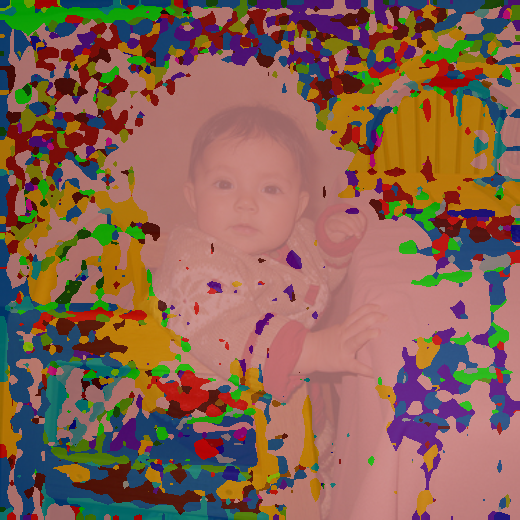

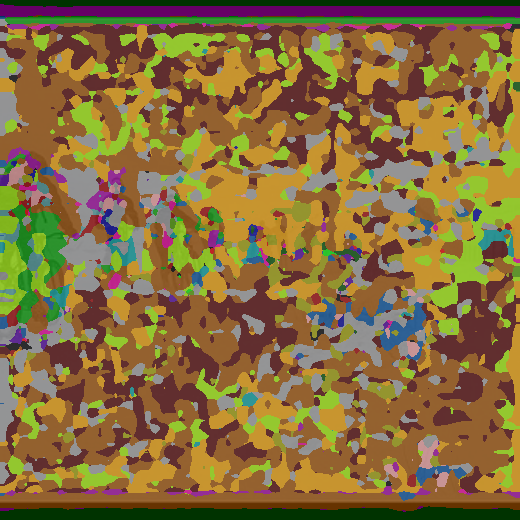

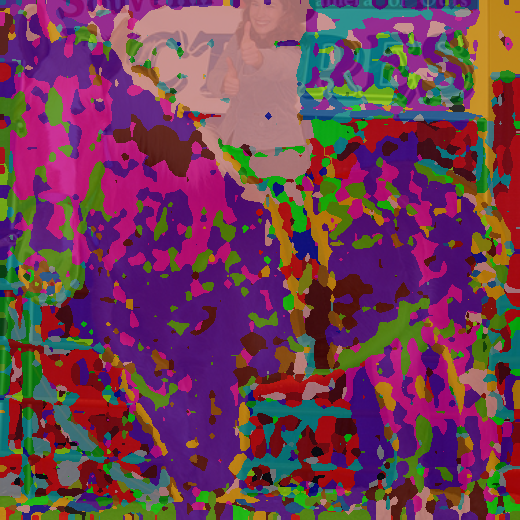

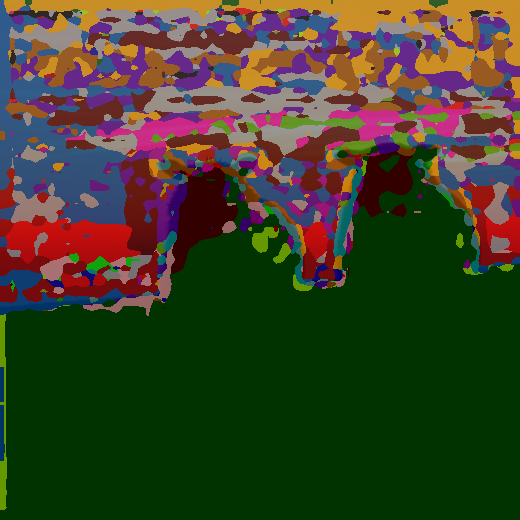

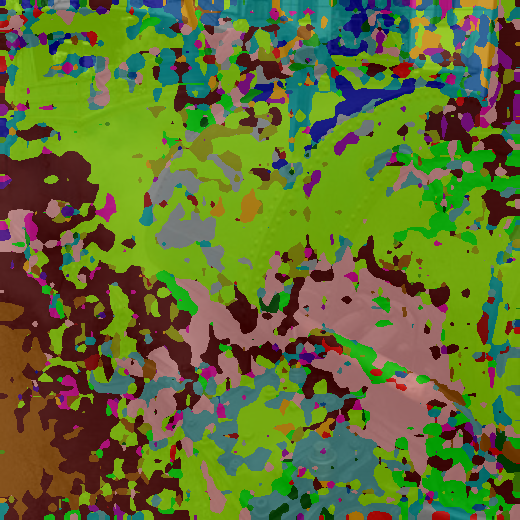

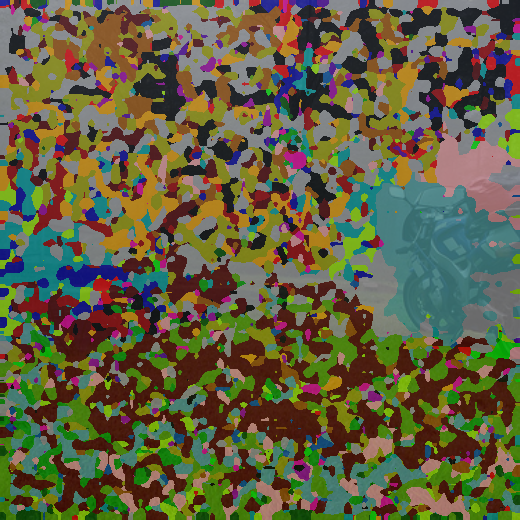

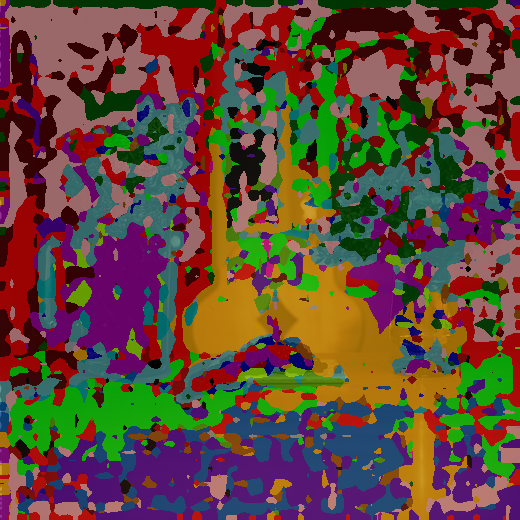

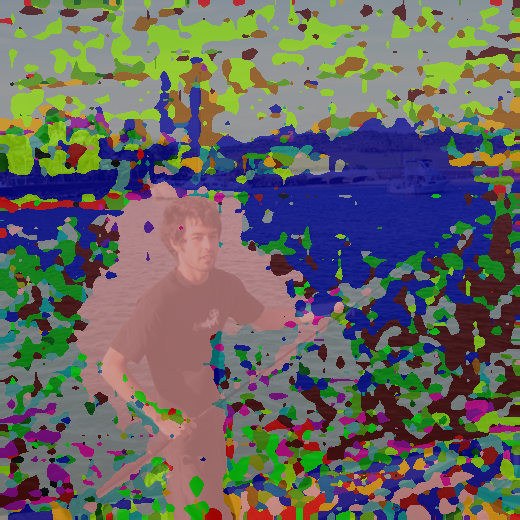

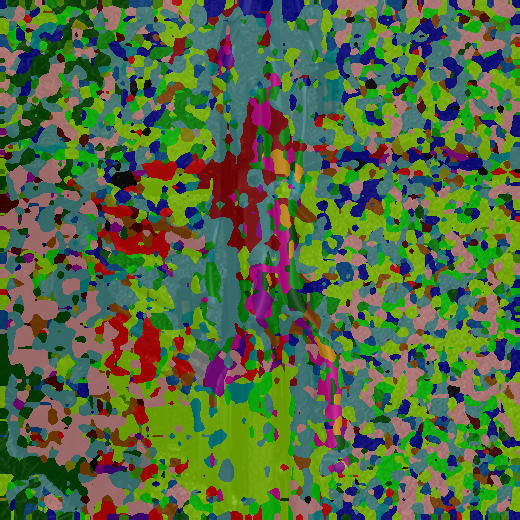

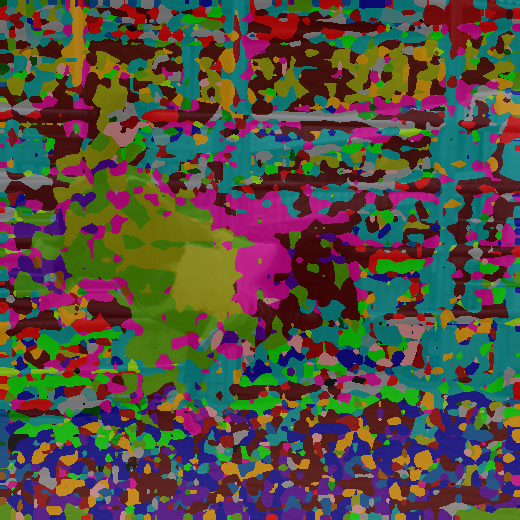

In [ ]:
for i, idx in enumerate(idxs):
    pr_ovr = draw_segmentation_masks(scs[i], prs_all_classes[i], colors=list(COLOR_MAP_DICT.values()))
    display(to_pil_image(pr_ovr))
    # torchvision.utils.save_image(prs[i], mask_prs_path / f"mask_pr_{idx}.png", value_range=(0, 255), normalize=True)